<a href="https://colab.research.google.com/github/kianahs/Machine-Learning/blob/main/wk8_Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Introduction

The aim of this lab is to get familiar with **Mixture of Gaussians** model.


1.   This lab is the course-work activity **Assignment 2: Unsupervised Learning(20%)**
2. The Assignment is due on **Friday , 1st December, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).

In [1]:
import os
import numpy as np
import scipy
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

For this lab, we will use the Peterson and Barney’s dataset of vowel formant frequencies. (For more info, look at Classification of Peterson & Barney’s vowels using Weka. - a copy of this article is on QMplus)

More specifically, Peterson and Barney measured the fundamental frequency $F0$ and the first three formant frequencies ($F1-F3$) of sustained English Vowels, using samples from various speakers.

Upload the .npy file and load it using the code block below.

In [2]:
from google.colab import files
files.upload()
data_npy_file = 'PB_data.npy'

# Loading data from .npy file
data = np.load(data_npy_file, allow_pickle=True)

Saving PB_data.npy to PB_data (1).npy


In [3]:
data

array({'f3': array([2850, 2790, 2640, ..., 3380, 2160, 2200], dtype=uint16), 'f2': array([2280, 2400, 2030, ..., 1140, 1850, 1830], dtype=uint16), 'f1': array([240, 280, 390, ..., 500, 740, 660], dtype=uint16), 'f0': array([160, 186, 203, ..., 334, 308, 328], dtype=uint16), 'phoneme_id': array([ 1,  1,  2, ...,  9, 10, 10], dtype=uint8)},
      dtype=object)

The dataset contains 4 vectors ($F0-F3$), containing the fundamental frequencies ($F0$, $F1$, $F2$ and $F3$) for each phoneme and another vector “phoneme\_id” containing a number representing the id of the phoneme.

In the exercises that follow, we will use only the dataset associated with formants $F1$ and $F2$.

**Note**: Phonemes and Frequencies are two different things; phoneme_id is the ground truth class of each row while frequencies represent features of each data point. Please review the papers provided with the lab materials for more details.

In [4]:
data = np.ndarray.tolist(data)
# Array that contains the phoneme ID (1-10) of each sample
phoneme_id = data['phoneme_id']

# frequencies f1 and f2
f1 = data['f1']
f2 = data['f2']

In [6]:
f1, f1.shape

(array([240, 280, 390, ..., 500, 740, 660], dtype=uint16), (1520,))

In [7]:
f2, f2.shape

(array([2280, 2400, 2030, ..., 1140, 1850, 1830], dtype=uint16), (1520,))

In [8]:
phoneme_id, phoneme_id.shape

(array([ 1,  1,  2, ...,  9, 10, 10], dtype=uint8), (1520,))

### <font color="maroon"> Q1. Produce a plot of $F1$ against $F2$. (You should be able to spot some clusters already in this scatter plot.). Comment on the figure and the visible clusters [2 marks]</font>

Text(0, 0.5, 'f2')

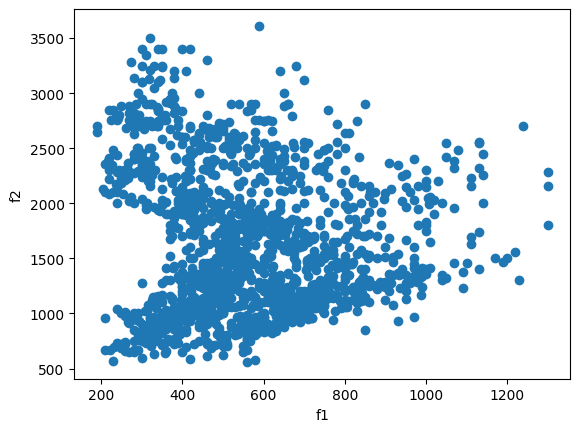

In [11]:
### your code here


plt.scatter(f1, f2)
plt.xlabel("f1")
plt.ylabel("f2")

# 1. MoG Using the EM algorithm

Recall the following definition of a Mixture of Gaussians. Assuming our observed random vector is $\mathbf{x}\in\mathbb{R}^D$, a MoG models $p(\mathbf{x})$ as a sum of $K$-many weighted Gaussians. More specifically:


\begin{equation}
 p(\mathbf{x}) = \sum_{k=1}^K \frac{p(c_{k})}{(2\pi)^{D/2} \mathrm{det}\left(\boldsymbol\Sigma_k\right)^{1/2}}
 % \exp(-\frac{1}{2}(x-\mu)^T \sum_{k}^{-1}(x-\mu))
 \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu_k)^\top {\boldsymbol\Sigma_k}^{-1}(\mathbf{x}-\boldsymbol\mu_k)\right),
\end{equation}
where:
* $\boldsymbol\mu_k\in\mathbb{R}^{D}$
* $\boldsymbol\Sigma_{k}\in\mathbb{R}^{D\times D}$
* $p(c_{k})=\pi_k\in\mathbb{R}$

denote the $k$-th gaussian component's **mean vector**, **covariance matrix**, and **mixture coefficients** respectively. The $K$-many gaussian components' model parameters are referred to collectively as $\theta = \{\boldsymbol\mu_k,\boldsymbol\Sigma_{k},\pi_k\}_{k=1}^K$.

## EM Algorithm
For the E step we softly assign each datum to the closest centroid (using the current iteration's fixed model parameters) as in the K means example.

For the M step we update the model parameters $\theta$ to maximize the weighted log-likelihood.
At a high level, for each centroid k we:
* Update the mean vectors
* Update the covariance matrices (We will fit Gaussians with diagonal covariance matrices)
* Set the mixture coefficients as the mean probability of a sample being generated by the k-th gaussian component

Read the code below and understand what it is calculating

In [ ]:
def get_predictions(mu, s, p, X):
	"""
		:param mu			: means of GMM components
		:param s			: covariances of GMM components
		:param p 			: weights of GMM components
		:param X			: 2D array of our dataset
	"""

	# get number of GMM components
	k = s.shape[0]
	# get number of data samples
	N = X.shape[0]
	# get dimensionality of our dataset
	D = X.shape[1]

	Z = np.zeros((N, k))
	for i in range(k):
		mu_i = mu[i, :]
		mu_i = np.expand_dims(mu_i, axis=1)
		mu_i_repeated = np.repeat(mu_i, N, axis=1)
		X_minus_mu = X - mu_i_repeated.transpose()
		inverse_s = scipy.linalg.pinv(s[i])
		inverse_s = np.squeeze(inverse_s)
		s_i_det = scipy.linalg.det(s[i])
		x_s_x = np.matmul(X_minus_mu, inverse_s)*X_minus_mu
		Z[:, i] = p[i]*(1/np.power(((2*np.pi)**D) * np.abs(s_i_det), 0.5)) * np.exp(-0.5*np.sum(x_s_x, axis=1))
	return Z


### Helper functions

In [ ]:
def plot_gaussians(ax, s, mu, X, title_string):
    """
        :param X            : 2D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param ax          : existing subplot, to draw on it
    """
    ax.clear()
    if X.shape[1] == 2:
        # set label of horizontal axis
        ax.set_xlabel('f1')
        # set label of vertical axis
        ax.set_ylabel('f2')
        # scatter the points, with red color
        ax.scatter(X[:,0], X[:,1], c='black', marker='.', label=title_string)

    k = s.shape[0]
    color_list = ['r', 'g', 'b', 'c', 'm', 'y']
    N_sides = 11

    # Iterate over all gaussians
    for k_cnt in range(k):

        # pick the covariance matrix and mean values of each gaussian
        s_k = s[k_cnt]
        mu_k = mu[k_cnt]

        if s_k.shape[0]==2:
            # dataset with 2 features
            side_range = np.arange(0, N_sides, 1)
            theta = side_range/(N_sides-1)*2*np.pi
            matrix = np.array([np.cos(theta), np.sin(theta)])
            mu_k = np.expand_dims(mu_k, axis=1)
            mu_repeated = np.repeat(mu_k, N_sides, axis=1)
            epoints = np.matmul(scipy.linalg.sqrtm(s_k), matrix) + mu_repeated
            plt.plot(epoints[0,:], epoints[1,:], color=color_list[k_cnt], linewidth=2)
            plt.scatter(mu_k[0], mu_k[1], color=color_list[k_cnt], marker='o', linewidth=2)
        elif s_k.shape[0]==3:
            # dataset with 3 features
            side_range = np.arange(0, N_sides, 1)
            theta = side_range/(N_sides-1)*np.pi
            phi = side_range/(N_sides-1)*2*np.pi
            sin_theta = np.expand_dims(np.sin(theta), axis=1)
            cos_theta = np.expand_dims(np.cos(theta), axis=1)
            sin_phi = np.expand_dims(np.sin(phi), axis=1)
            cos_phi = np.expand_dims(np.cos(phi), axis=1)
            sx = np.matmul(sin_theta, cos_phi.transpose())
            sy = np.matmul(sin_theta, sin_phi.transpose())
            sz = np.matmul(cos_theta, np.ones((1, N_sides)))
            svect = np.array([sx.reshape((N_sides*N_sides)), sy.reshape((N_sides*N_sides)), sz.reshape((N_sides*N_sides))])

            mu_k = np.expand_dims(mu_k, axis=1)
            mu_repeated = np.repeat(mu_k, N_sides*N_sides, axis=1)
            epoints = np.matmul(scipy.linalg.sqrtm(s_k), svect) + mu_repeated

            ex = epoints[0]
            ey = epoints[1]
            ez = epoints[2]

            ax.plot3D(epoints[0,:], epoints[1,:], epoints[2,:], color=color_list[k_cnt])
            ax.plot3D(ex, ey, ez, color=color_list[k_cnt])
        else:
            print('Each dataset sample should have either 2 or 3 features. Not plotting this one.')
    ax.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

def plot_data_3D(X, title_string, ax):
    """
        :param X            : 2D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param ax          : existing subplot, to draw on it
    """
    # clear subplot from previous (if any) drawn stuff
    ax.clear()
    # set label of x axis
    ax.set_xlabel('f1')
    # set label of y axis
    ax.set_ylabel('f2')
    # set label of z axis
    ax.set_zlabel('f1 + f2')
    # scatter the points, with red color
    ax.scatter3D(X[:,0], X[:,1], X[:,2], c='black', marker='.', label=title_string)
    # add legend to the subplot
    ax.legend()


def save_model(mu, s, p):
  GMM_parameters = {}
  GMM_parameters['mu'] = mu
  GMM_parameters['s'] = s
  GMM_parameters['p'] = p
  if not os.path.isdir('data/'):
    os.mkdir('data/')
  npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
  np.save(npy_filename, GMM_parameters)

## Train MoG

Read the following blocks of code and understand what it does.

In [ ]:
k = 3
# id of the phoneme that will be used (e.g. 1, or 2)
p_id = 1
X_full = np.zeros((len(f1), 2))
X_full[:,0] = f1.copy()
X_full[:,1] = f2.copy()
X_full = X_full.astype(np.float32)

X = X_full[phoneme_id==p_id,:]

In [ ]:
# get number of samples
N = X.shape[0]
# get dimensionality of our dataset
D = X.shape[1]
# common practice : GMM weights initially set as 1/k
p = np.ones((k))/k
# GMM means are picked randomly from data samples
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # shape kxD
# covariance matrices
s = np.zeros((k,D,D)) # shape kxDxD
# number of iterations for the EM algorithm
n_iter = 100

# initialize covariances
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    # initially set to fraction of data covariance
    s[i,:,:] = cov_matrix/k

# Initialize array Z that will get the predictions of each Gaussian on each sample
Z = np.zeros((N,k)) # shape Nxk

###############################
# run Expectation Maximization algorithm for n_iter iterations
n_iter = 100
for t in range(n_iter):
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')

    # Do the M-step:
    for i in range(k):
        mu[i,:] = np.matmul(X.transpose(),Z[:,i]) / np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with diagonal covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)
        coef_1 = (X.transpose() - mu_i_repeated)**2
        coef_2 = Z[:,i]/np.sum(Z[:,i])
        coef_2 = np.expand_dims(coef_2, axis=1)
        res_1 = np.squeeze( np.matmul(coef_1, coef_2) )
        s[i,:,:] = np.diag(res_1)

        p[i] = np.mean(Z[:,i])

    fig, ax1 = plt.subplots()
    plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
print('\nFinished.\n')
print(mu, s)
save_model(mu, s, p)

### <font color="maroon"> Q2. Run the code multiple times for $K=3$, what do you observe? Use figures and the printed MoG parameters to support your arguments [2 mark] </font>
###  Q3. Repeat the training for phoneme_id = 2  and save the parameters [1 mark]
### Q4. Repeat training for $K=6$ for phoneme_id =1 and phoneme_id=2 and save the model parameters [1 mark]

Save your MoG model: this should comprise the variables mu, s and p. Include the all the saved model parameters in the submission .zip folder.

In [ ]:
### your code here

### <font color="maroon"> Q5. Use the 2 MoGs ($K=3$) learnt in tasks 2 & 3 to build a classifier to discriminate between phonemes 1 and 2, and explain the process in the report [4 marks] </font>

Classify using the Maximum Likelihood (ML) criterion and calculate the miss-classification error. Remember that a classification under the ML compares $p(\mathbf{x};\boldsymbol\theta_{1})$, where $\boldsymbol\theta_{1}$ are the parameters of the MoG learnt for the first phoneme, with $p(\mathbf{x};\boldsymbol\theta_{2})$, where $\boldsymbol\theta_{2}$  are the parameters of the MoG learnt for the second phoneme.

In [ ]:
k = 3
inds_1 = np.where(phoneme_id==1)
inds_2 = np.where(phoneme_id==2)
inds_1 = inds_1[0]
inds_2 = inds_2[0]
inds_1_and_2 = np.concatenate((inds_1, inds_2), axis=0)

X = X_full[inds_1_and_2,:]

N = X.shape[0]
D = X.shape[1]

# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 1
p_id = 1
npy_filename = 'data/GMM_params_phoneme_{:02}_k_{:02}.npy'.format(p_id, k)
if os.path.isfile(npy_filename):
    GMM_parameters_phoneme_1 = np.load(npy_filename, allow_pickle=True)
    GMM_parameters_phoneme_1 = np.ndarray.tolist(GMM_parameters_phoneme_1)
else:
    raise('File {} does not exist.'.format(npy_filename))
mu = GMM_parameters_phoneme_1['mu']
s = GMM_parameters_phoneme_1['s']
p = GMM_parameters_phoneme_1['p']

# Initialize array Z_phoneme_1 that will get the predictions of each Gaussian on each sample
Z_phoneme_1 = np.zeros((N,k)) # shape Nxk

# get predictions
###your code here


# Get predictions on both phonemes 1 and 2, from a GMM with k components, pretrained on phoneme 2
p_id = 2
###your code here

# classify each point using Maximum Likelihood

### your code here

# calculate accuracy
### your code here

### <font color="maroon"> Q6. Repeat for $K=6$ and compare the results in terms of accuracy. [2 mark] </font>


### <font color="maroon"> Q7. Display a "classification matrix" assigning labels to a grid of all combinations of the $F1$ and $F2$ features for the $K=3$ classifiers from above. Next, repeat this step for $K=6$ and compare the two. [3 marks] </font>

In particular,
create a custom uniform grid of points that spans all possible intermediate combinations of $F1$ and $F2$ features, using the features' minimum and maximum values as the limits. (Hint: check documentation for [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) and [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) ). Classify each point in the grid using one of your classifiers. That is, create a classification matrix, $\mathbf{M}$, whose elements are either 0 or 1. $M(i,j)$ is 0 if the point at location $(i,j)$ on the custom grid is classified as belonging to phoneme 1, and is 1 otherwise.

### Hint: building the custom grid:
Assuming our data were the orange points below, the custom grid would look something like the following (evenly spaced points spanning the minimum to maximum values of both features):

![](https://i.imgur.com/khfYx42.png)



In [ ]:
k = 3

X = X_full[inds_1_and_2,:]

N = X.shape[0]
D = X.shape[1]

min_f1 = int(np.min(X[:,0]))
max_f1 = int(np.max(X[:,0]))
min_f2 = int(np.min(X[:,1]))
max_f2 = int(np.max(X[:,1]))
N_f1 = max_f1 - min_f1
N_f2 = max_f2 - min_f2
print('f1 range: {}-{} | {} points'.format(min_f1, max_f1, N_f1))
print('f2 range: {}-{} | {} points'.format(min_f2, max_f2, N_f2))

#########################################
# Write your code here

# Create a custom grid of shape N_f1 x N_f2
# The grid will span all the values of (f1, f2) pairs, between [min_f1, max_f1] on f1 axis, and between [min_f2, max_f2] on f2 axis
# Then, classify each point [i.e., each (f1, f2) pair] of that grid, to either phoneme 1, or phoneme 2, using the two trained GMMs
# Do predictions, using GMM trained on phoneme 1, on custom grid
# Do predictions, using GMM trained on phoneme 2, on custom grid
# Compare these predictions, to classify each point of the grid
# Store these prediction in a 2D numpy array named "M", of shape N_f2 x N_f1 (the first dimension is f2 so that we keep f2 in the vertical axis of the plot)
# M should contain "0.0" in the points that belong to phoneme 1 and "1.0" in the points that belong to phoneme 2
########################################/

################################################
# Visualize predictions on custom grid

# Create a figure
#fig = plt.figure()
fig, ax = plt.subplots()

# use aspect='auto' (default is 'equal'), to force the plotted image to be square, when dimensions are unequal
plt.imshow(M, aspect='auto')

# set label of x axis
ax.set_xlabel('f1')
# set label of y axis
ax.set_ylabel('f2')

# set limits of axes
plt.xlim((0, N_f1))
plt.ylim((0, N_f2))

# set range and strings of ticks on axes
x_range = np.arange(0, N_f1, step=50)
x_strings = [str(x+min_f1) for x in x_range]
plt.xticks(x_range, x_strings)
y_range = np.arange(0, N_f2, step=200)
y_strings = [str(y+min_f2) for y in y_range]
plt.yticks(y_range, y_strings)

# set title of figure
title_string = 'Predictions on custom grid'
plt.title(title_string)

# add a colorbar
plt.colorbar()

N_samples = int(X.shape[0]/2)
plt.scatter(X[:N_samples, 0] - min_f1, X[:N_samples, 1] - min_f2, marker='.', color='red', label='Phoneme 1')
plt.scatter(X[N_samples:, 0] - min_f1, X[N_samples:, 1] - min_f2, marker='.', color='green', label='Phoneme 2')

# add legend to the subplot
plt.legend()
plt.show()

Create a new dataset that will contain 3 columns, as follows:
\begin{equation}
    X = [F1, F2, F1+F2]
\end{equation}

### <font color="maroon"> Q8. Try to fit a MoG model to the new data. What is the problem that you observe? Explain why it occurs [2 marks]

In [ ]:
p_id = 1 # id of the phoneme that will be used (e.g. 1, or 2)

k = 3 # number of GMM components
X = np.zeros((len(f1), 3))
#########################################
# Write your code here
# The shape of X is be two-dimensional. Each row will represent a sample of the dataset, and each column will represent a feature (e.g. f1 or f2 or f1+f2)
# Store f1 in the first column of X, f2 in the second column of X and f1+f2 in the third column of X
# Filter X to, contain only samples that belong to the chosen phoneme.







#########################################
fig = plt.figure()
ax1 = plt.axes(projection='3d')
title_string = 'Phoneme {}'.format(p_id)
plot_data_3D(X=X, title_string=title_string, ax=ax1)

N, D = X.shape
p = np.ones((k))/k
random_indices = np.floor(N*np.random.rand((k)))
random_indices = random_indices.astype(int)
mu = X[random_indices,:] # shape kxD
s = np.zeros((k,D,D)) # shape kxDxD
n_iter = 150

# initialize covariances
for i in range(k):
    cov_matrix = np.cov(X.transpose())
    s[i,:,:] = cov_matrix/k

Z = np.zeros((N,k)) # shape Nxk

###############################
# run Expectation Maximization algorithm for n_iter iterations
for t in range(n_iter):
    #print('****************************************')
    print('Iteration {:03}/{:03}'.format(t+1, n_iter))

    # Do the E-step
    Z = get_predictions(mu, s, p, X)
    Z = normalize(Z, axis=1, norm='l1')
    # Do the M-step:
    for i in range(k):
        mu[i,:] = np.matmul(X.transpose(), Z[:,i])/np.sum(Z[:,i])

        ###################################################
        # We will fit Gaussians with full covariance matrices:
        mu_i = mu[i,:]
        mu_i = np.expand_dims(mu_i, axis=1)
        mu_i_repeated = np.repeat(mu_i, N, axis=1)

        term_1 = X.transpose() - mu_i_repeated
        term_2 = np.repeat(np.expand_dims(Z[:,i], axis=1), D, axis=1) * term_1.transpose()
        s[i,:,:] = np.matmul(term_1, term_2)/np.sum(Z[:,i])
        p[i] = np.mean(Z[:,i])

plot_gaussians(ax1, 2*s, mu, X, 'Phoneme {}'.format(p_id))
plt.show()

### <font color="maroon"> Q9. Suggest ways of overcoming the singularity problem and implement one of them. Show any training outputs in the report and discuss. [3 marks] </font>

In [ ]:
#########################################
# Write your code here